In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pickle
import json

from shapely import wkt

from joblib import Parallel, delayed
import multiprocessing

import scipy.stats as stats
from scipy.spatial import distance
from sklearn.preprocessing import OrdinalEncoder
from easydict import EasyDict as edict
from tqdm import tqdm

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk

import powerlaw

In [3]:
# import sys
# sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils.utils import setup_seed, load_config

In [4]:
import matplotlib.pyplot as plt
import matplotlib

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)


colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]


In [5]:
def _apply_parallel(ls, func, n=-1, **kwargs):
    """parallel apply for spending up."""
    length = len(ls)
    cpunum = multiprocessing.cpu_count()
    if length < cpunum:
        spnum = length
    if n < 0:
        spnum = cpunum + n + 1
    else:
        spnum = n or 1

    return Parallel(n_jobs=n, verbose=0)(delayed(func)(seq, **kwargs) for seq in ls)

# Duration and mode
## Reading

In [377]:
file_dir = [    
    ".\\data\\validation\\na_layer2_allDouble_14_200_1_200.json",
]

LENGTH = 50
MIN_PER_DAY = 60*24

pred_df_all = []
tgt_df = pd.DataFrame()

tgt = {
    "loc": [],
    "dur": [],
    "mode":[],
    "idx": [],
    "day": [],
    "day_min":[],
}
src = {
    "loc":[],
    "dur":[],
    "mode":[],
    "idx":[],
}

def get_unpadded_sequence(content, dataset="target"):
    locations = np.array(content[dataset])
    if dataset=="target":
        dur_seq = "tgt_dur"
        mode_seq = "tgt_mode"
    else:
        dur_seq = "src_dur"
        mode_seq = "src_mode"
    # durations = (np.array(content[dur_seq]) + 1) / 2 * (MIN_PER_DAY * 2)
    durations = np.array(content[dur_seq])
    modes = np.array(content[mode_seq])
    try:
        length = np.where(locations == 0)[0][0]
        
        locations = locations[:length]
        durations = durations[:length]
        modes = modes[:length]
    except IndexError:
        pass

    return locations, durations, modes
    
for i, file in enumerate(file_dir):
    predict = {
        "loc": [],
        "dur": [],
        "mode":[],
        "idx": [],
        "day": [],
        "day_min":[],
    }
    with open(file, "r") as f_reader:
        for record_idx, row in enumerate(f_reader):
            content = json.loads(row)
            src_locs, src_dur, src_mode = get_unpadded_sequence(content, dataset="source")
            
            start_time = np.array(content["seq_time"])[len(src_locs) - 1]

            if i == 0:
                src["idx"].extend(np.repeat(record_idx,len(src_locs)))
                src["loc"].extend(src_locs)
                src["dur"].extend(src_dur)
                src["mode"].extend(src_mode)
                
                tgt_locs, tgt_dur, tgt_mode = get_unpadded_sequence(content, dataset="target")

                tgt["idx"].extend(np.repeat(record_idx,len(tgt_locs)))
                tgt["loc"].extend(tgt_locs)
                tgt["dur"].extend(tgt_dur)
                tgt["mode"].extend(tgt_mode)

                abs_time = start_time + np.cumsum(tgt_dur)
                tgt["day"].extend((abs_time // MIN_PER_DAY).astype(int))
                tgt["day_min"].extend(abs_time % MIN_PER_DAY)

            predict["idx"].extend(np.repeat(record_idx,LENGTH))
            predict["loc"].extend(np.array(content["recover"][:LENGTH]).squeeze())
            predict["mode"].extend(np.array(content["mode"][:LENGTH]).squeeze())
            
            duration = np.array(content["duration"][:LENGTH]).squeeze()
            predict["dur"].extend(duration)
            
            abs_time = start_time + np.cumsum(duration)
            predict["day"].extend((abs_time // MIN_PER_DAY).astype(int))
            predict["day_min"].extend(abs_time % MIN_PER_DAY)

    if  i == 0:
        src_df = pd.DataFrame(src)
        tgt_df = pd.DataFrame(tgt)
    pred_df_all.append(pd.DataFrame(predict))

In [378]:
print(tgt_df["loc"].max(), src_df["loc"].max())
print([df["loc"].max() for df in pred_df_all])

28742 28742
[28737]


In [379]:
for df in pred_df_all:
    df.loc[df["loc"]>28742, "loc"] = 28742

# 14882 -> 14976 (28743 -> 28800)

In [380]:
diff_file_name = [name.split("\\")[-1].split(".")[0] for name in file_dir]
# diff_file_name = ["Diffusion (Ours)"]
# diff_file_name = ["Base", "Base + xy + POI"]
diff_file_name 

['na_layer2_allDouble_14_200_1_200']

## Duration distribution

In [381]:
duration_df_all = []
for df in pred_df_all:
    new_df = df.copy()
    new_df.loc[new_df["dur"]<1, "dur"] = 1

    duration_df_all.append(new_df)

In [382]:
duration_df_all[0]["dur"].mean(), pred_df_all[0]["dur"].mean(), duration_df_all[0]["dur"].describe()

(600.9017218448419,
 600.895148589778,
 count    1.814250e+06
 mean     6.009017e+02
 std      4.133259e+02
 min      1.000000e+00
 25%      2.402813e+02
 50%      5.402490e+02
 75%      9.115447e+02
 max      2.880000e+03
 Name: dur, dtype: float64)

In [383]:
tgt_df["dur_log"] = np.log(tgt_df["dur"]+1)
tgt_df["dur_log"].describe()

count    1.732822e+06
mean     4.894099e+00
std      1.451053e+00
min      0.000000e+00
25%      3.850148e+00
50%      4.875197e+00
75%      6.070738e+00
max      7.965893e+00
Name: dur_log, dtype: float64

In [384]:
def pdf(data, xmin=None, xmax=None, linear_bins=False, bins=None, **kwargs):
    """
    Returns the probability density function (normalized histogram) of the
    data.

    Parameters
    ----------
    data : list or array
    xmin : float, optional
        Minimum value of the PDF. If None, uses the smallest value in the data.
    xmax : float, optional
        Maximum value of the PDF. If None, uses the largest value in the data.
    linear_bins : float, optional
        Whether to use linearly spaced bins, as opposed to logarithmically
        spaced bins (recommended for log-log plots).

    Returns
    -------
    bin_edges : array
        The edges of the bins of the probability density function.
    probabilities : array
        The portion of the data that is within the bin. Length 1 less than
        bin_edges, as it corresponds to the spaces between them.
    """
    from numpy import logspace, histogram, floor, unique,asarray
    from math import ceil, log10
    data = asarray(data)
    if not xmax:
        xmax = max(data)
    if not xmin:
        xmin = min(data)

    if xmin<1:  #To compute the pdf also from the data below x=1, the data, xmax and xmin are rescaled dividing them by xmin.
        xmax2=xmax/xmin
        xmin2=1
    else:
        xmax2=xmax
        xmin2=xmin

    if bins is not None:
        bins = bins
    elif linear_bins:
        bins = range(int(xmin2), ceil(xmax2)+1)
    else:
        log_min_size = log10(xmin2)
        log_max_size = log10(xmax2)
        number_of_bins = ceil((log_max_size-log_min_size)*10)
        bins = logspace(log_min_size, log_max_size, num=number_of_bins)
        bins[:-1] = floor(bins[:-1])
        bins[-1] = ceil(bins[-1])
        bins = unique(bins)

    if xmin<1: #Needed to include also data x<1 in pdf.
        hist, edges = histogram(data/xmin, bins, density=True)
        edges=edges*xmin # transform result back to original
        hist=hist/xmin # rescale hist, so that np.sum(hist*edges)==1
    else:
        hist, edges = histogram(data, bins, density=True)

    return edges, hist

def trim_to_range(data, xmin=None, xmax=None, **kwargs):
    """
    Removes elements of the data that are above xmin or below xmax (if present)
    """
    from numpy import asarray
    data = asarray(data)
    if xmin:
        data = data[data>=xmin]
    if xmax:
        data = data[data<=xmax]
    return data
    
def cdf(data,
    xmin=None, xmax=None,
    survival=False, **kwargs):
    """
    The cumulative distribution function (CDF) of the data.

    Parameters
    ----------
    data : list or array, optional
    survival : bool, optional
        Whether to calculate a CDF (False) or CCDF (True). False by default.
    xmin : int or float, optional
        The minimum data size to include. Values less than xmin are excluded.
    xmax : int or float, optional
        The maximum data size to include. Values greater than xmin are
        excluded.

    Returns
    -------
    X : array
        The sorted, unique values in the data.
    probabilities : array
        The portion of the data that is less than or equal to X.
    """

    from numpy import array
    data = array(data)
    if not data.any():
        from numpy import nan
        return array([nan]), array([nan])

    data = trim_to_range(data, xmin=xmin, xmax=xmax)

    n = float(len(data))
    from numpy import sort
    data = sort(data)
    all_unique = not( any( data[:-1]==data[1:] ) )

    if all_unique:
        from numpy import arange
        CDF = arange(n)/n
    else:
#This clever bit is a way of using searchsorted to rapidly calculate the
#CDF of data with repeated values comes from Adam Ginsburg's plfit code,
#specifically https://github.com/keflavich/plfit/commit/453edc36e4eb35f35a34b6c792a6d8c7e848d3b5#plfit/plfit.py
        from numpy import searchsorted, unique
        CDF = searchsorted(data, data,side='left')/n
        unique_data, unique_indices = unique(data, return_index=True)
        data=unique_data
        CDF = CDF[unique_indices]

    if survival:
        CDF = 1-CDF
    return data, CDF

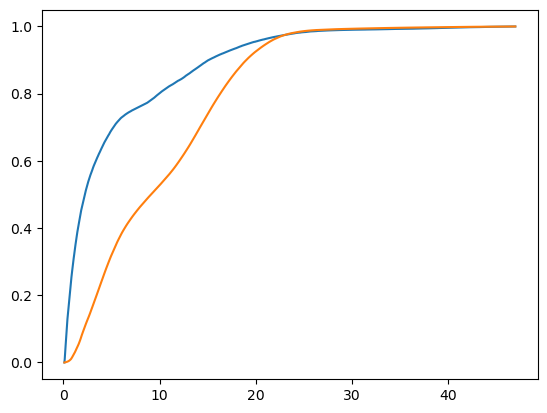

In [385]:
bins, CDF = cdf((tgt_df["dur"]+1) / 60, xmin=0.1, xmax=47, survival=False)
plt.plot(bins, CDF)

bins, CDF = cdf(duration_df_all[0]["dur"] / 60, xmin=0.1, xmax=47, survival=False)
plt.plot(bins, CDF)

plt.show()

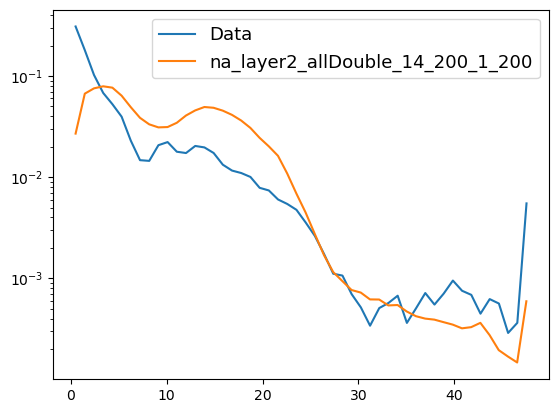

In [386]:
# edges, hist = pdf((tgt_df["dur"]+1) / 60, linear_bins=False)
# bin_centers = (edges[1:]+edges[:-1])/2.0
# hist[hist==0] = np.nan
# plt.plot(bin_centers, hist)

edges, hist = pdf((tgt_df["dur"]+1) / 60, xmin=0.1, xmax=40, linear_bins=True, bins=50)
bin_centers = (edges[1:]+edges[:-1])/2.0
hist[hist==0] = np.nan
plt.plot(bin_centers, hist, label="Data")

# edges, hist = pdf(duration_df_all[0]["dur"] / 60, linear_bins=False)
# bin_centers = (edges[1:]+edges[:-1])/2.0
# hist[hist==0] = np.nan
# plt.plot(bin_centers, hist)

edges, hist = pdf(duration_df_all[0]["dur"] / 60, xmin=0.1, xmax=40, linear_bins=True, bins=50)
bin_centers = (edges[1:]+edges[:-1])/2.0
hist[hist==0] = np.nan
plt.plot(bin_centers, hist, label=diff_file_name[0])


# plt.xscale("log")
plt.yscale("log")
plt.legend(prop={"size": 13})

plt.show()

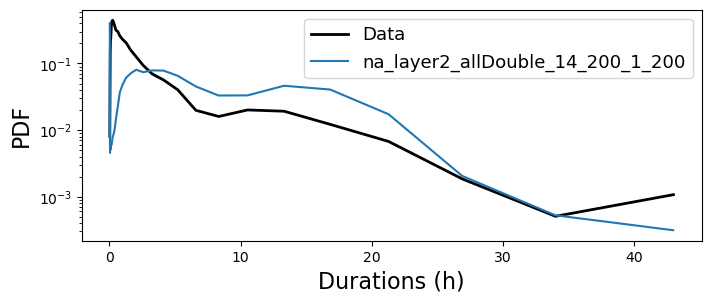

In [387]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

x = np.linspace(0, np.max(tgt_df["dur"]), 500)

# ax.plot(x, density(x), label="true")

powerlaw.plot_pdf((tgt_df["dur"]+1) / 60, linear_bins=False, label="Data", color="k", linewidth=2)

# powerlaw.plot_pdf((src_df.loc[src_df["dur"] != 0, "dur"].values +1)/ 60, label="Source", color="k", alpha=0.5, linewidth=2)
for curr_df, label in zip(duration_df_all, diff_file_name):
    powerlaw.plot_pdf(curr_df["dur"] /60, linear_bins=False, label=label)

plt.xscale("linear")
# plt.yscale("linear")

# plt.ylim(10**-12, 10**-2)
# plt.xlim(10**-1, 2880)

plt.legend(prop={"size": 13})
plt.xlabel("Durations (h)", fontsize=16)
plt.ylabel("PDF", fontsize=16)

# plt.savefig(r'.\metrics\figures\duration.png', bbox_inches='tight', dpi=600)
plt.show()

## Mode distribution

In [388]:
['Bicycle', 'Bus', 'Car', 'Other', 'Train', 'Tram', 'Walk']

['Bicycle', 'Bus', 'Car', 'Other', 'Train', 'Tram', 'Walk']

In [389]:
unique, counts = np.unique(tgt_df["mode"], return_counts=True)
print(unique)
print(counts/counts.sum() * 100)

_, counts = np.unique(src_df["mode"], return_counts=True)
print(counts/counts.sum() * 100)

[1 2 3 4 5 6 7]
[ 6.3223  4.4523 43.0755  0.1214  8.5339  1.5537 35.941 ]
[ 7.1085  4.3518 43.7059  0.1358  7.2782  1.4057 36.014 ]


In [390]:
for pred_df, label in zip(pred_df_all, diff_file_name):
    curr_arr = np.array(pred_df["mode"])
    unique, counts = np.unique(curr_arr, return_counts=True)
    print(label)
    print(unique)
    print(counts/counts.sum() * 100)

na_layer2_allDouble_14_200_1_200
[1 2 3 4 5 6 7]
[ 5.9208  1.6664 58.7749  0.0211  2.4795  0.1282 31.0091]


### Divergence

In [391]:
_, true_counts = np.unique(tgt_df["mode"], return_counts=True)
true_counts = true_counts/true_counts.sum()

_, src_counts = np.unique(src_df["mode"], return_counts=True)
src_counts = src_counts/src_counts.sum()
print(distance.jensenshannon(src_counts, true_counts))

for pred_df, label in zip(pred_df_all, diff_file_name):
    print(label)
    _, pred_counts = np.unique(pred_df["mode"], return_counts=True)

    try: 
        print(distance.jensenshannon(pred_counts[1:]/pred_counts.sum(), true_counts))
    except ValueError:
        print(distance.jensenshannon(pred_counts/pred_counts.sum(), true_counts))

0.019992347669414528
na_layer2_allDouble_14_200_1_200
0.15121442102797486


### Pie plot

## Location per day

In [371]:
def get_day_unique_locs(df):
    _, counts = np.unique(df.groupby(["idx", "day"])["loc"].nunique(), return_counts=True)
    return counts/counts.sum()

tgt_unique_counts = get_day_unique_locs(tgt_df)

In [372]:
pred_unique_counts_ls = [get_day_unique_locs(df) for df in pred_df_all]

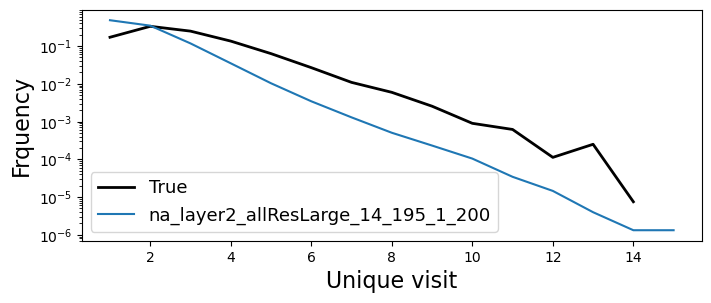

In [373]:
plt.figure(figsize=(8, 3))

# plotting
plt.plot(np.arange(len(tgt_unique_counts)) + 1, tgt_unique_counts, color="k", linewidth=2, label="True")

for pred_unique_counts, label in zip(pred_unique_counts_ls, diff_file_name):
    plt.plot(np.arange(len(pred_unique_counts)) + 1, pred_unique_counts, label=label)

# plt.xscale("log")
plt.yscale("log")
plt.legend(prop={"size": 13})

plt.xlabel("Unique visit", fontsize=16)
plt.ylabel("Frquency", fontsize=16)

# plt.savefig(r'.\metrics\figures\lk.png', bbox_inches='tight', dpi=600)
plt.show()

In [374]:
def get_day_locs(df):
    _, counts = np.unique(df.groupby(["idx", "day"])["loc"].count(), return_counts=True)
    return counts/counts.sum()

tgt_counts = get_day_locs(tgt_df)

In [375]:
pred_counts_ls = [get_day_locs(df) for df in pred_df_all]

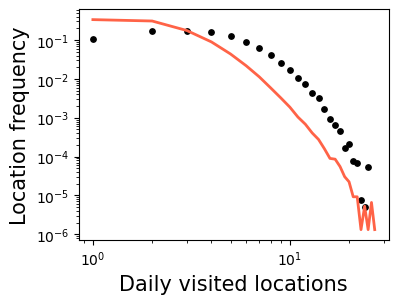

In [376]:
plt.figure(figsize=(4, 3))

# plotting
plt.scatter(np.arange(len(tgt_counts)) + 1, tgt_counts, color="k", s=15, label="True")

for pred_counts, label in zip(pred_counts_ls, diff_file_name):
    plt.plot(np.arange(len(pred_counts)) + 1, pred_counts, color="tomato", linewidth=2, label=label)

plt.xscale("log")
plt.yscale("log")
# plt.legend(prop={"size": 13})

plt.xlabel("Daily visited locations", fontsize=15)
plt.ylabel("Location frequency", fontsize=15)

# plt.savefig(r'.\metrics\figures\daily_lk.png', bbox_inches='tight', dpi=600)
plt.show()

## Active time during day

In [354]:
tgt_df["min_bin_15"] = tgt_df["day_min"] // 15

pred_active_all = []
for pred_df in pred_df_all:
    pred_df["min_bin_15"] = pred_df["day_min"] // 15
    pred_active_all.append(pred_df)


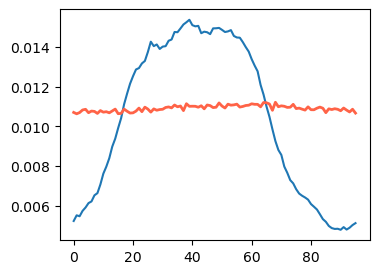

In [355]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

active = tgt_df.groupby("min_bin_15").size().values
plt.plot(np.arange(len(active)), active/active.sum())

for pred_df, label in zip(pred_active_all, diff_file_name):
    active_pred = pred_df.groupby("min_bin_15").size().values
    plt.plot(np.arange(len(active_pred)), active_pred/active.sum(), color="tomato", linewidth=2, label=label)

plt.show()

## Motifs

In [314]:
import networkx as nx
from networkx.algorithms import isomorphism


def _construct_graph(df):
    G = nx.DiGraph()
    G.add_nodes_from(df["loc"])

    G.add_edges_from(df.iloc[:-1][["loc", "next_loc"]].astype(int).values)

    in_degree = np.all([False if degree == 0 else True for _, degree in G.in_degree])
    out_degree = np.all([False if degree == 0 else True for _, degree in G.out_degree])
    if in_degree and out_degree:
        return G


def get_graphs(df_valid):
    graphs_ls = []
    for uniq_visits in tqdm(range(1, 7)):
        curr_df = df_valid.loc[df_valid["uniq_visits"] == uniq_visits].copy()
        curr_df["next_loc"] = curr_df["loc"].shift(-1)
    
        if uniq_visits == 1:
            graph_s = curr_df.groupby(["idx", "day"]).size().rename("class").reset_index()
            graph_s["class"] = 0
            graph_s["uniq_visits"] = uniq_visits
            
            graphs_ls.append(graph_s)
            # daily_records.append(len(curr_graph))
            continue
    
        # the edge number shall be at least the node number
        curr_edge_num = curr_df.groupby(["idx", "day"]).size() - 1
        valid_user_days = curr_edge_num[curr_edge_num >= uniq_visits].rename("edge_num")
        curr_df = curr_df.merge(valid_user_days.reset_index(), on=["idx", "day"], how="left")
        curr_df = curr_df.loc[~curr_df["edge_num"].isna()]
    
        if uniq_visits == 2:
            graph_s = curr_df.groupby(["idx", "day"]).size().rename("class").reset_index()
            graph_s["class"] = 0
            graph_s["uniq_visits"] = uniq_visits
        
            graphs_ls.append(graph_s)
            continue
    
        graph_df = curr_df.groupby(["idx", "day"]).apply(_construct_graph, include_groups=False)
        if len(graph_df) == 0:
            continue
        # filter graphs that do not have an in-degree and out degree
        graph_df = graph_df.loc[~graph_df.isna()]
        graphs = graph_df.values
    
        motifs_groups = []
        for i in range(graphs.shape[0] - 1):
            if i in [item for sublist in motifs_groups for item in sublist]:
                continue
            possible_match = [i]
            for j in range(i + 1, graphs.shape[0]):
                if isomorphism.GraphMatcher(graphs[i], graphs[j]).is_isomorphic():
                    possible_match.append(j)
            motifs_groups.append(possible_match)
        # print(len(graphs))
        # print(len([item for sublist in motifs_groups for item in sublist]))
    
        graph_df = graph_df.rename("graphs").reset_index()
        class_arr = np.zeros(len(graph_df))
        for i, classes in enumerate(motifs_groups):
            class_arr[classes] = i
        graph_df["class"] = class_arr
        graph_df["class"] = graph_df["class"].astype(int)
        graph_df["uniq_visits"] = uniq_visits

        graph_df.drop(columns={"graphs"}, inplace=True)
    
        graphs_ls.append(graph_df)
    return pd.concat(graphs_ls)


            
def _label_classes(graphs_ls):
    total_motifs = np.sum([len(num) for num in graphs_ls])

    all_user_days = []
    for i, graph in enumerate(graphs_ls):
        if i == 0 or i == 1:
            res = graph.drop(columns={"size"})
            res["class"] = i * 10
            all_user_days.append(res)
        else:
            prop = graph["class"].value_counts() / total_motifs * 100
            valid_class = prop[prop > 0.5].index
            res = graph.loc[graph["class"].isin(valid_class)].copy()
            res = res.drop(columns={"graphs"})
            res["class"] = i * 10 + res["class"]
            all_user_days.append(res)

    return pd.concat(all_user_days)
    
def get_motifs(df, proportion_filter=0.005):
    df = df.copy()

    # delete the self transitions
    df["loc_next"] = df["loc"].shift(-1)
    df["day_next"] = df["day"].shift(-1)
    df = df.loc[~((df["loc_next"] == df["loc"]) & (df["day_next"] == df["day"]))].copy()
    df.drop(columns=["loc_next", "day_next"], inplace=True)

    user_days = df.groupby(["idx", "day"]).agg({"loc": "nunique"})
    value_counts = user_days.value_counts()

    # the fraction of daily location visit <= 6 locations
    print(value_counts.head(6).sum() / value_counts.sum())
    
    # the mean daily location visit
    print(user_days.mean().values[0])

    # only select daily location visit < 7 records
    valid_user_days = user_days[user_days<7]
    valid_user_days.rename(columns={"loc": "uniq_visits"}, inplace=True)
    valid_user_days = valid_user_days.dropna()
    
    valid_user_days = valid_user_days.astype(int)

    df_valid = df.merge(valid_user_days.reset_index(), on=["idx", "day"], how="left")
    df_valid = df_valid.loc[~df_valid["uniq_visits"].isna()]
    
    # check daily location visit filter is correct
    # print(df_valid.groupby(["idx", "day"]).agg({"loc": "nunique"}).value_counts())
    # print(df_valid)

    graphs_ls = get_graphs(df_valid)

    total_graphs = len(graphs_ls)
    def _get_valid_motifs(df):
        if (len(df) / total_graphs) > proportion_filter:
            return df

    # get the valid motifs per user days
    motifs_user_days = (
        graphs_ls.groupby(["uniq_visits", "class"], as_index=False).apply(_get_valid_motifs).reset_index(drop=True)
    )
    # merge back to all user days
    return_df = (
        df_valid.groupby(["idx", "day"])
        .size()
        .rename("visits")
        .reset_index()
        .merge(motifs_user_days, on=["idx", "day"], how="left")
    )

    return return_df

In [315]:
tgt_motifs = get_motifs(tgt_df)

0.978697857778934
2.769686221146053


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:20<00:00, 13.38s/it]
C:\Users\hong\AppData\Local\Temp\ipykernel_25108\101965760.py:140: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  graphs_ls.groupby(["uniq_visits", "class"], as_index=False).apply(_get_valid_motifs).reset_index(drop=True)


In [316]:
pred_motifs_ls = [get_motifs(df) for df in pred_df_all]

0.9688122183457846
2.8867459756228033


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:48<00:00, 18.13s/it]
C:\Users\hong\AppData\Local\Temp\ipykernel_25108\101965760.py:140: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  graphs_ls.groupby(["uniq_visits", "class"], as_index=False).apply(_get_valid_motifs).reset_index(drop=True)


In [317]:
def _get_motifs_proportion(df):
    return (len(df["class"]) - df["class"].isna().sum()) / len(df["class"])

print("Mobility motifs proportion across users:")
print(f"True: {_get_motifs_proportion(tgt_motifs):.3f}")

for pred_motifs, label in zip(pred_motifs_ls, diff_file_name):
    print(label + f": {_get_motifs_proportion(pred_motifs):.3f}")

Mobility motifs proportion across users:
True: 0.346
na_layer6_14_200_1_200: 0.402


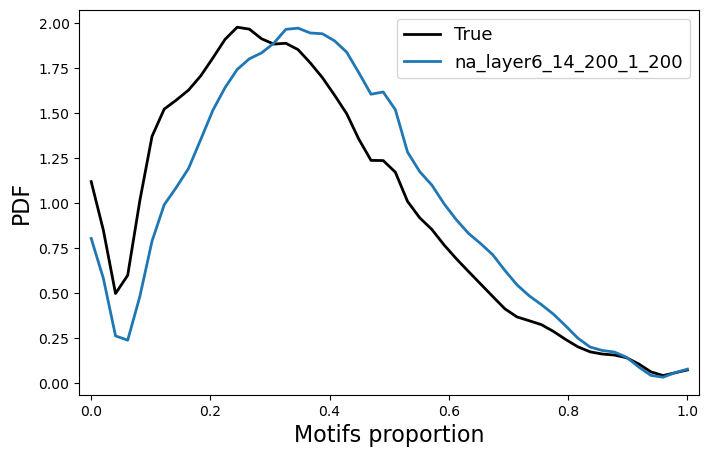

In [318]:
# plot the user distribution of all motifs
plt.figure(figsize=(8, 5))

# plotting
x = np.linspace(0, 1, 50)

# get the user density
user_motifs_proportion = tgt_motifs.groupby("idx").apply(_get_motifs_proportion, include_groups=False).values
Density = stats.gaussian_kde(user_motifs_proportion)
plt.plot(x, Density(x), color="k", linewidth=2, label="True")

for pred_motifs, label in zip(pred_motifs_ls, diff_file_name):
    user_motifs_proportion = pred_motifs.groupby("idx").apply(_get_motifs_proportion, include_groups=False).values
    Density = stats.gaussian_kde(user_motifs_proportion)

    plt.plot(x, Density(x), linewidth=2, label=label)

plt.xlim([-0.02, 1.02])
plt.xlabel("Motifs proportion", fontsize=16)
plt.ylabel("PDF", fontsize=16)

plt.legend(prop={"size": 13})
plt.show()

Text(0, 0.5, 'Proportion')

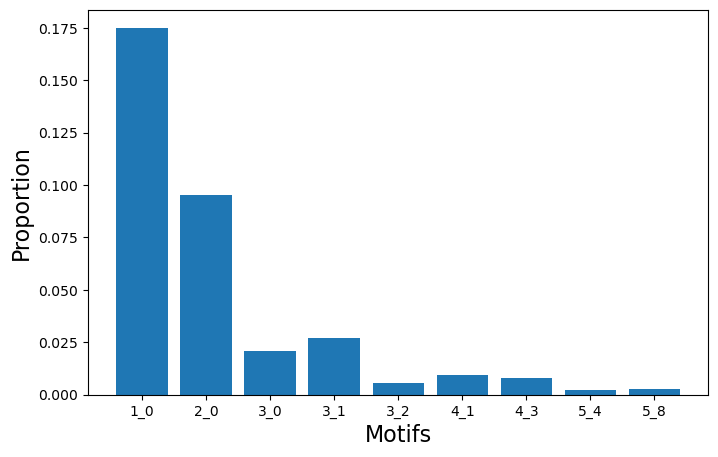

In [319]:
# plot the motifs distribution for all user days
plt.figure(figsize=(8, 5))

# get the proportion of each motif type for y-axis
motifs_frq = (
    tgt_motifs.rename(columns={"size": "uniq_visits"}).dropna(subset="class").groupby(["uniq_visits", "class"], as_index=False).size().reset_index(drop=True)
)
motifs_frq["size"] = motifs_frq["size"] / len(tgt_motifs)
# create unique labels for x-axis
motifs_frq["label"] = (
    motifs_frq["uniq_visits"].astype(int).astype(str) + "_" + motifs_frq["class"].astype(int).astype(str)
)

# plotting
x = np.arange(len(motifs_frq["label"]))
plt.bar(x=x, height=motifs_frq["size"], tick_label=motifs_frq["label"])
plt.xlabel("Motifs", fontsize=16)
plt.ylabel("Proportion", fontsize=16)

# plt.savefig(os.path.join(log_dir, "Mean motifs distribution.png"), bbox_inches="tight", dpi=600)

Text(0, 0.5, 'Proportion')

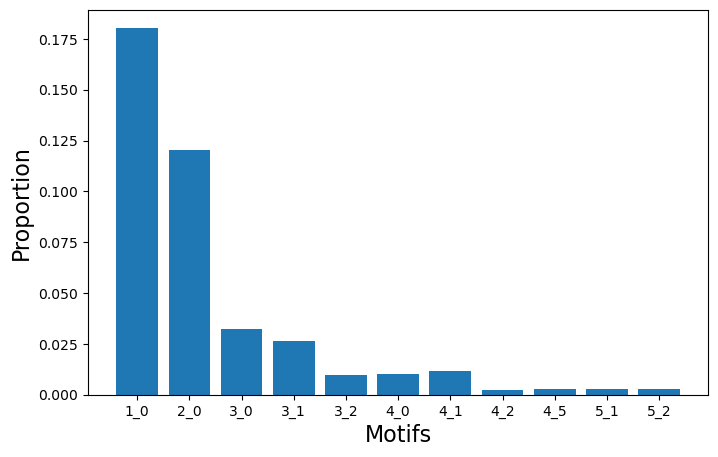

In [320]:
# plot the motifs distribution for all user days
plt.figure(figsize=(8, 5))

# get the proportion of each motif type for y-axis
motifs_frq = (
    pred_motifs_ls[0].rename(columns={"size": "uniq_visits"}).dropna(subset="class").groupby(["uniq_visits", "class"], as_index=False).size().reset_index(drop=True)
)
motifs_frq["size"] = motifs_frq["size"] / len(pred_motifs_ls[0])
# create unique labels for x-axis
motifs_frq["label"] = (
    motifs_frq["uniq_visits"].astype(int).astype(str) + "_" + motifs_frq["class"].astype(int).astype(str)
)

# plotting
x = np.arange(len(motifs_frq["label"]))
plt.bar(x=x, height=motifs_frq["size"], tick_label=motifs_frq["label"])
plt.xlabel("Motifs", fontsize=16)
plt.ylabel("Proportion", fontsize=16)

# plt.savefig(os.path.join(log_dir, "Mean motifs distribution.png"), bbox_inches="tight", dpi=600)

In [622]:
motifs_frq

,uniq_visits,class,size,label
0,1.0,0.0,0.180311,1_0
1,2.0,0.0,0.120361,2_0
2,3.0,0.0,0.032512,3_0
3,3.0,1.0,0.026382,3_1
4,3.0,2.0,0.009839,3_2
5,4.0,0.0,0.009958,4_0
6,4.0,1.0,0.011431,4_1
7,4.0,2.0,0.002192,4_2
8,4.0,5.0,0.002860,4_5
9,5.0,1.0,0.002833,5_1


## Trip packages

In [278]:
def applyParallel(dfGrouped, func):
    # multiprocessing.cpu_count()
    retLst = Parallel(n_jobs=multiprocessing.cpu_count())(
        delayed(func)(group) for _, group in dfGrouped
    )
    return pd.concat(retLst)

### Unique locations

In [287]:
def _get_loc_evolution_idx(df):
    evolution = np.zeros(len(df))

    for i in range(len(df)):
        evolution[i] = len(set(df.iloc[:i]["loc"]))

    result = pd.DataFrame({"evolution": evolution, "idx": df["idx"].index[0]})
    result["step"] = np.arange(len(result))
    return result

def get_loc_evolution(df):
    loc_evolution = applyParallel(df.groupby("idx"), _get_loc_evolution_idx)
    groupby_evolution = loc_evolution.groupby("step")["evolution"]
    return groupby_evolution.mean(), groupby_evolution.size()




In [288]:
tgt_mean, tgt_size = get_loc_evolution(tgt_df)

In [289]:
pre_mean, pre_size = get_loc_evolution(pred_df_all[0])

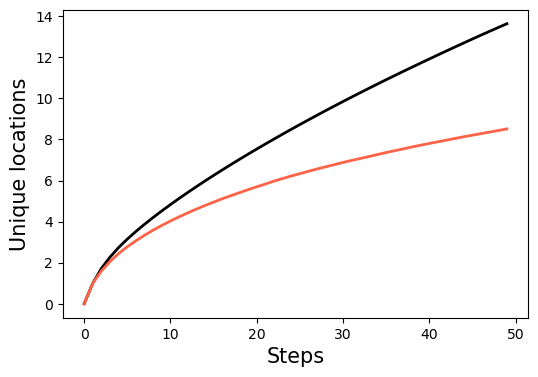

In [290]:
# plot the motifs distribution for all user days
plt.figure(figsize=(6, 4))

x = tgt_mean.index.values
plt.plot(x, tgt_mean, color="k", linewidth=2, label="True")
plt.plot(x, pre_mean, color="tomato", linewidth=2, label=diff_file_name)

# plt.xscale("log")
# plt.yscale("log")

plt.xlabel("Steps", fontsize=15)
plt.ylabel("Unique locations", fontsize=15)


x**0.6

plt.show()

In [184]:
def _get_loc_evolution_idx_time(df, max_time=693):
    evolution = np.zeros(int(max_time+1))
    loc = df["loc"].values
    for i in range(len(df)):
        evolution[int(df.iloc[i]["1h_bin"])] = len(set(loc[:i]))

    evolution_df = pd.DataFrame(evolution)
    evolution_df.replace(0, np.nan, inplace=True)
    evolution = evolution_df.ffill().replace(np.nan, 0).values
    return np.concatenate(evolution)

def get_loc_evolution_time(df):
    df = df.copy()
    df["total_min"] = df["day"]*60*24 + df["day_min"]
    df["1h_bin"] = df["total_min"]//60

    tqdm.pandas(desc="get_loc_evolution_time")
    hour = df.groupby("idx").progress_apply(_get_loc_evolution_idx_time, max_time=df["1h_bin"].max())
    
    return np.vstack(hour.values).mean(axis=0)

In [185]:
tgt_mean_time = get_loc_evolution_time(tgt_df)

get_loc_evolution_time: 100%|███████████████████████████████████████████████████| 36285/36285 [01:44<00:00, 347.59it/s]


In [186]:
pre_mean_time = get_loc_evolution_time(pred_df_all[0])

get_loc_evolution_time: 100%|███████████████████████████████████████████████████| 36285/36285 [01:58<00:00, 304.96it/s]


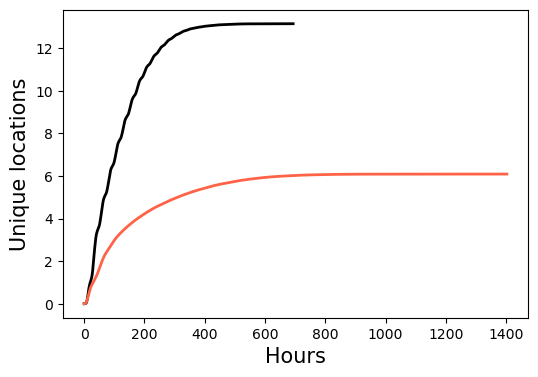

In [188]:
# plot the motifs distribution for all user days
plt.figure(figsize=(6, 4))

plt.plot(np.arange(len(tgt_mean_time)), tgt_mean_time, color="k", linewidth=2, label="True")
plt.plot(np.arange(len(pre_mean_time)), pre_mean_time, color="tomato", linewidth=2, label=diff_file_name)

# plt.xscale("log")
# plt.yscale("log")

plt.xlabel("Hours", fontsize=15)
plt.ylabel("Unique locations", fontsize=15)

plt.show()

### Construct

### Unique trip packages